# CNN (convolutional neural network)

# Part 1 : Introduction

In [40]:
import numpy as np
import matplotlib.pyplot as plt
# convolution function
from scipy.signal import convolve2d
#  to read image from url
from imageio import imread
# to display image
from PIL import Image

import torch
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import torchvision
import torchvision.transforms as T # provides all the transformations of images
from torch.utils.data import DataLoader, Dataset

<Figure size 1000x1000 with 0 Axes>

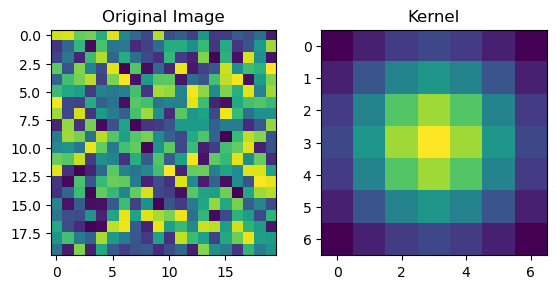

In [29]:
imageN = 20
image = np.random.rand(imageN, imageN)
# convolution kernel
kernelN = 7
Y,X = np.meshgrid(np.linspace(-3,3,kernelN), np.linspace(-3,3,kernelN))
kernel = np.exp(-(X**2 + Y**2)/7) # Gaussian kernel

plt.figure(figsize=(10,10))
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[1].imshow(kernel)
ax[1].set_title('Kernel')
plt.show()

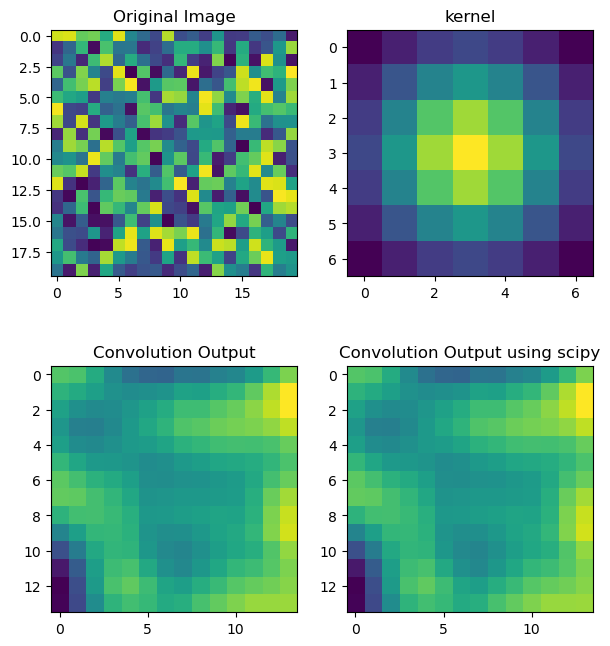

In [31]:
# convolution
convoutput = np.zeros((imageN-kernelN+1, imageN-kernelN+1))
for rowi in range(imageN-kernelN+1):
    for coli in range(imageN-kernelN+1):
        # we flip the kernel before applying it for real convolution operation (cross-correlation)
        convoutput[rowi,coli] = np.sum(image[rowi:rowi+kernelN,coli:coli+kernelN] * kernel[::-1,::-1])


fig, ax = plt.subplots(2,2, figsize=(7,8))
ax[0,0].imshow(image)
ax[0,0].set_title('Original Image')
ax[0,1].imshow(kernel)
ax[0,1].set_title('kernel')
ax[1,0].imshow(convoutput)
ax[1,0].set_title('Convolution Output')
ax[1,1].imshow(convolve2d(image, kernel, mode='valid'))
ax[1,1].set_title('Convolution Output using scipy')
plt.show()

**Notes**

 - Convolution of `n-D` kernel is always `One` number (same as 2D and 1D).

 - Odd kernel sizes are ofter used to have exact center.

 - Edges always cause deficulties. We deal with this through padding.

 - Image convolution in DL also involves down-sampling, this down via stride and pooling.

 - In the convolution operation the kernel should be flipped, iotherwise if we didn't flip the operation will be `Cross-Correlation`

 - The convolution of $ n \times n $ matrix by $ k \times k $ kernel result $ (n - k + 1) \times (n - k + 1) $ matrix.

    - example: 
        - **Input Matrix** $ 4 \times 4 $ :
            $$
            \begin{bmatrix}
            1 & 2 & 3 & 1 \\
            2 & 3 & 6 & 7 \\
            5 & 5 & 8 & 0 \\
            3 & 1 & 0 & 0 \\
            \end{bmatrix}
            $$

        - **Kernel** $ 3 \times 3 $ :
                $$
                \begin{bmatrix}
                1 & 0 & -1 \\
                1 & 0 & -1 \\
                1 & 0 & -1 \\
                \end{bmatrix}
                $$

        - **Output Matrix** $ 2 \times 2 $:
                $$
                \begin{bmatrix}
                9 & -2 \\
                4 & -2 \\
                \end{bmatrix}
                $$



**Kernels**
  
   - Kernels are filters that extract features(edges,corners) from an image. The same kernel applied to different images will give differeny feature maps.

   - Kernels are relativaly small   $3 \times 3 $ ,  $5 \times 5$ and even $ 7 \times 7 $

   - In traditional image precessing the kernels setting was done manually by researchers, But now in using DL the kernels begin random and are learned through gradient descent, kernels are same for all images.

   - Kernels are not used to classify or make decisions, insted they are used to extract features. Those features are used for classification. So the CNN architecture is basically like that : a lot of layers that do convolutions and then feed forwad layers in the very end. 

   - It's important to have kernels sum to zero because that prevent the kernel itself to add offset, but in DL we should not worry about that because the model will learn.
   

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_17036\1812527465.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(urlimg)


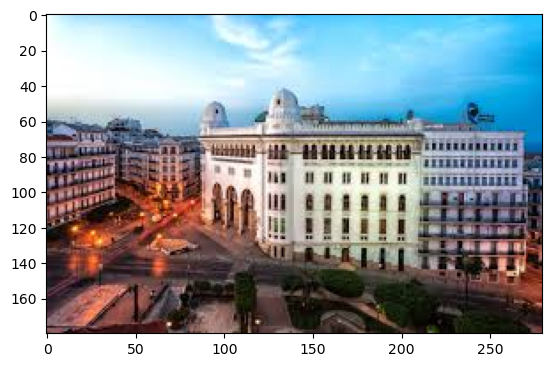

In [23]:
urlimg = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTBLdOLY7qD2n-rqSuvUK6vfNYZRwbaOlaCCg&s'
img = imread(urlimg)
# display image
plt.imshow(img)
plt.show()

In [24]:
print('Image shape:', img.shape)

Image shape: (180, 280, 3)


Image shape: (180, 280)


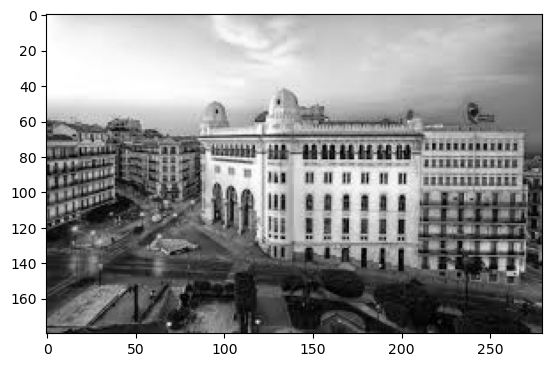

In [25]:
img = np.mean(img,axis=2) # convert to grayscale
print('Image shape:', img.shape)


plt.imshow(img, cmap='gray')
plt.show()

In [26]:
# vertical and horizontal edge detection
vk = np.array(
    [
        [1,0,-1],
        [1,0,-1],
        [1,0,-1]
        ]      
    )

hk = np.array(
    [
        [1,1,1],
        [0,0,0],
        [-1,-1,-1]
        ]      
    )


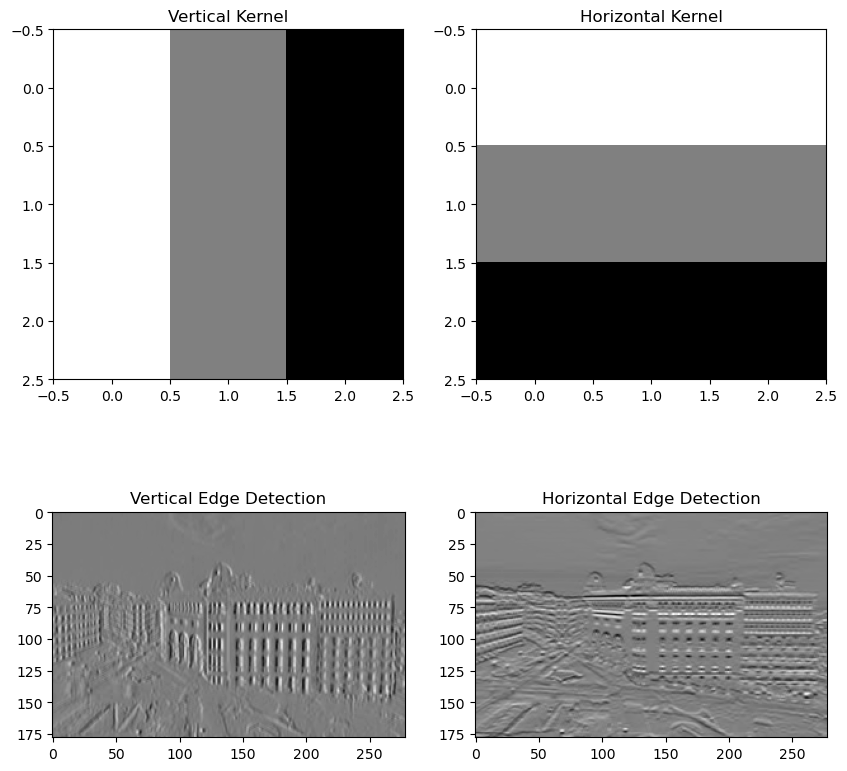

In [27]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(vk, cmap='gray')
ax[0,0].set_title('Vertical Kernel')
ax[0,1].imshow(hk, cmap='gray')
ax[0,1].set_title('Horizontal Kernel')
ax[1,0].imshow(convolve2d(img, vk, mode='valid'), cmap='gray')
ax[1,0].set_title('Vertical Edge Detection')
ax[1,1].imshow(convolve2d(img, hk, mode='valid'), cmap='gray')
ax[1,1].set_title('Horizontal Edge Detection')
plt.show()

### Pytorch implementation of kernels

In [36]:
vk_t = torch.tensor(vk, dtype=torch.float32).view(1,1,3,3)
# kernel size should be 4D (batch_size, channels, height, width)
# we have 1 batch, 1 channel, 3x3 kernel
# so we add 1,1 to the beginning of the shape
hk_t = torch.tensor(hk, dtype=torch.float32).view(1,1,3,3)
img_t = torch.tensor(img, dtype=torch.float32).view(1,1,img.shape[0],img.shape[1])
vk_t.shape, hk_t.shape, img_t.shape

(torch.Size([1, 1, 3, 3]),
 torch.Size([1, 1, 3, 3]),
 torch.Size([1, 1, 180, 280]))

In [37]:
vk_t 

tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]])

In [38]:
C = F.conv2d(img_t, vk_t)
print(C.shape)

torch.Size([1, 1, 178, 278])


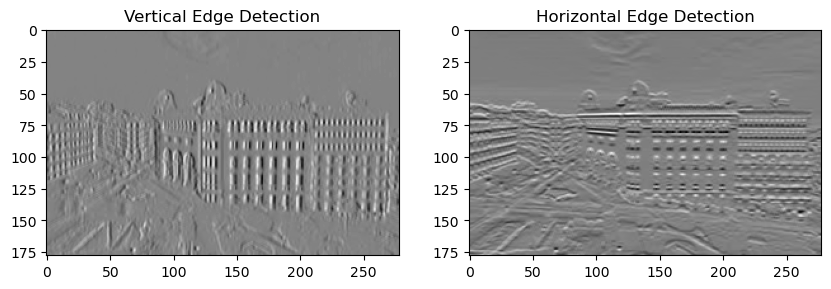

In [39]:
fig,ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(C[0,0].detach().numpy(), cmap='gray')
ax[0].set_title('Vertical Edge Detection')
C = F.conv2d(img_t, hk_t)
ax[1].imshow(C[0,0].detach().numpy(), cmap='gray')
ax[1].set_title('Horizontal Edge Detection')
plt.show()

**Padding**
  
  - Padding is used to increase the size of the result of convolution, or match with the previous layer (or image).

  - Padding involves insterting at least 1 rows/columns.

  - Added rows/columns are symetric.

  - Padded number are usually zeros. It's also possible to wrap the image from top-to-bottom (circular convolution).

**Stride**

 - Stride is used to decrease the size of the result of convolution. It is a mechanism of down-sampling, and reduces the number of params in CNN.

 - The stride parameter is an integer (skip value). Stride = 1 is the default value which give the full result.

 - Strind is usually the same for rows/columns, but can be different when warranted (case of rectangle image of shape $ n \times m $).

**Image size in given layer**

 $$ N_h = \lfloor \frac{M_h + 2p - k}{s_h} \rfloor + 1  $$ 

  - $N_h$ : Number of pixels in current layer.

  - $2p$ : Padding.

  - $k$ : Kernel size $k*k$.

  - $s_h$ : Stride.

## Convolution in **Pytorch**

In [5]:
# create a conv2d class instance with params

# params 

inChans = 3 # RGB
outChans = 15 # 15 feature maps that's means 15 filters (kernel)
kernelSize = 5 # kernel size
stride = 1 # stride
padding = 0 # padding

# create the instance (similar to nn.Linear)
conv = torch.nn.Conv2d(inChans, outChans, kernelSize, stride, padding)
print(conv)
print('Size of weights:', conv.weight.shape)
print('Size of bias:', conv.bias.shape) # each filter has a his own bias

Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
Size of weights: torch.Size([15, 3, 5, 5])
Size of bias: torch.Size([15])


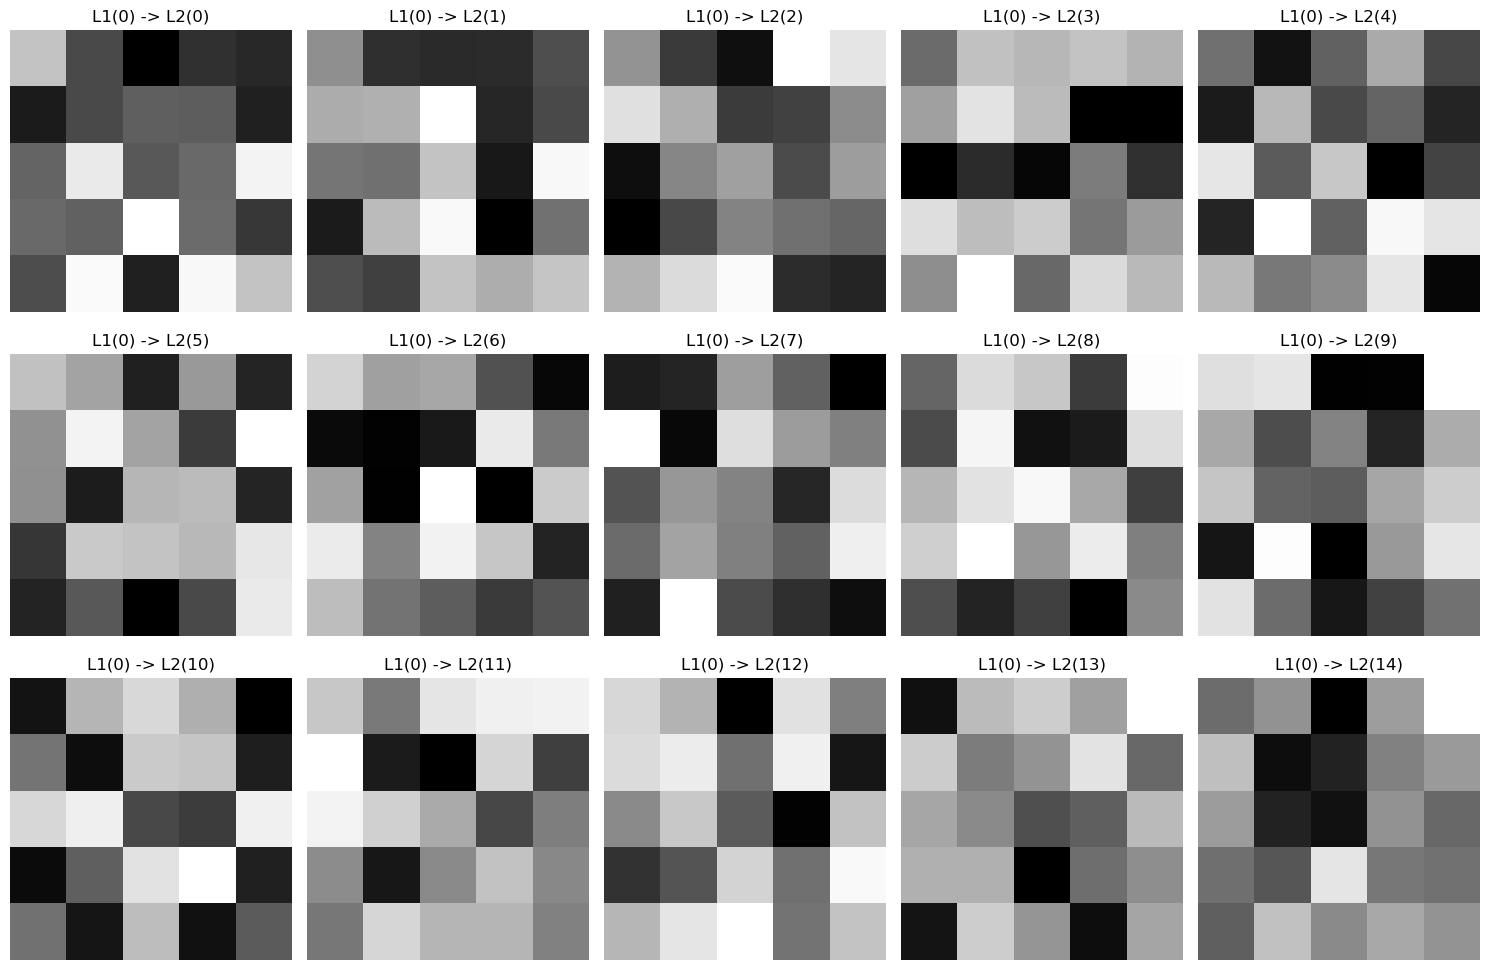

In [27]:
# What does this kernels look like?
def show_kernels(ker_channel):
    fig, ax = plt.subplots(3,5, figsize=(15,10))
    for i ,ax in enumerate(ax.flatten()):
        ax.imshow(torch.squeeze(conv.weight[i,ker_channel,:,:]).detach(), cmap='gray')
        ax.set_title(f'L1(0) -> L2({i})')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
show_kernels(0)    

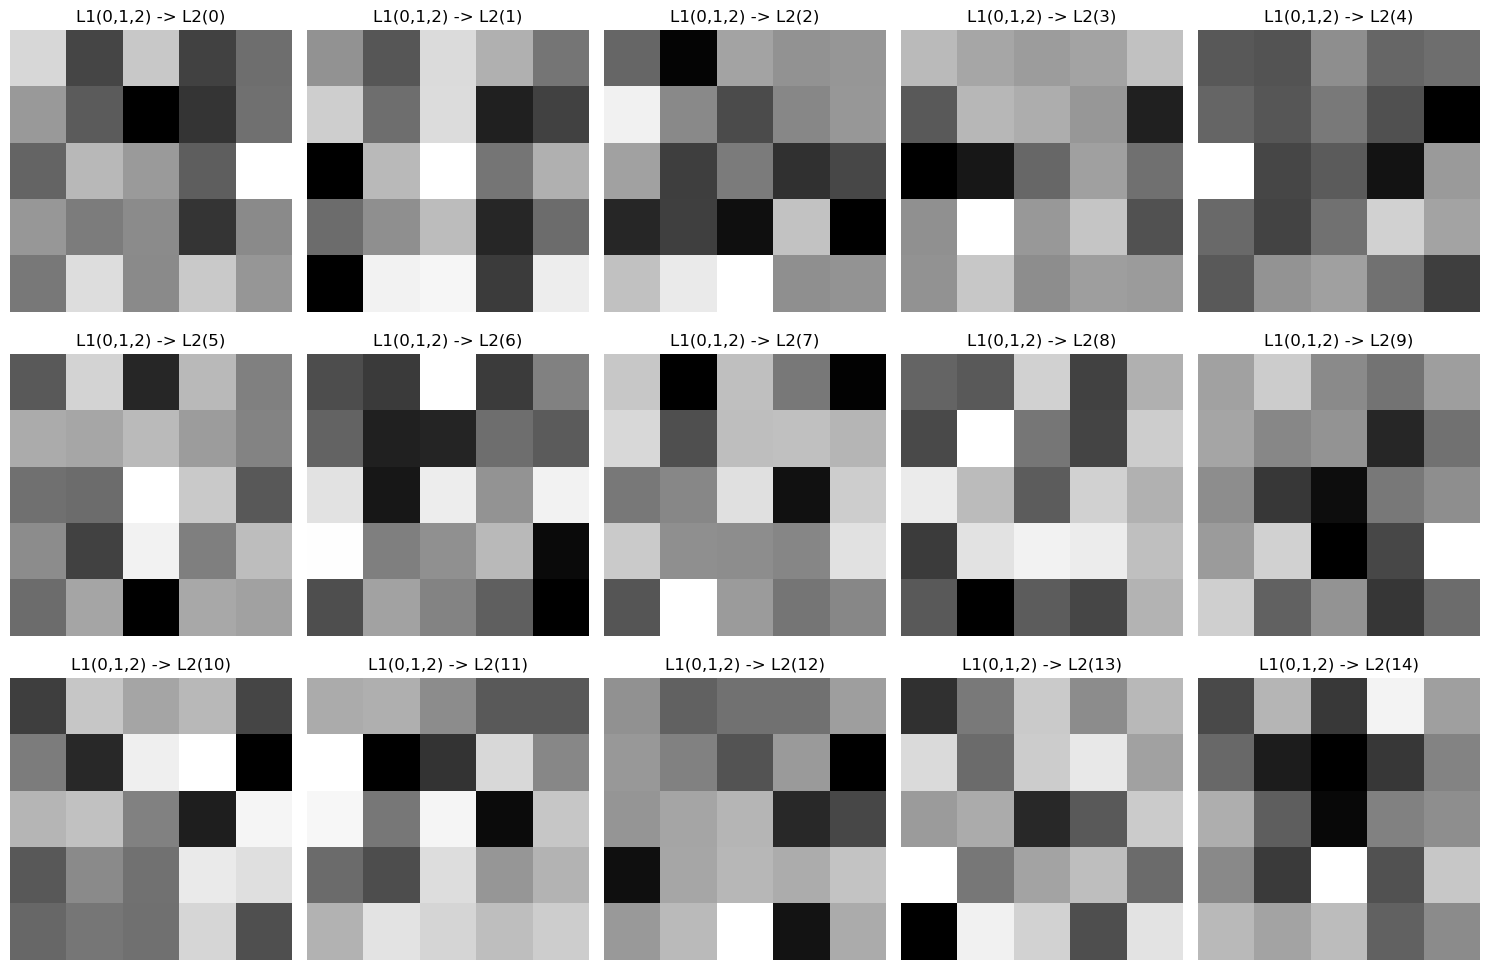

In [28]:
def show_kernels_all_channels():
    fig, ax = plt.subplots(3,5, figsize=(15,10))

    for i, ax in enumerate(ax.flatten()):
        kernel = torch.sum(conv.weight[i, :3, :, :], dim=0)  # Sum over first 3 channels
        ax.imshow(kernel.detach(), cmap='gray')
        ax.set_title(f'L1(0,1,2) -> L2({i})')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_kernels_all_channels()    


## Convolve with an image 

torch.Size([1, 3, 64, 64])
(64, 64, 3, 1)
(64, 64, 3)


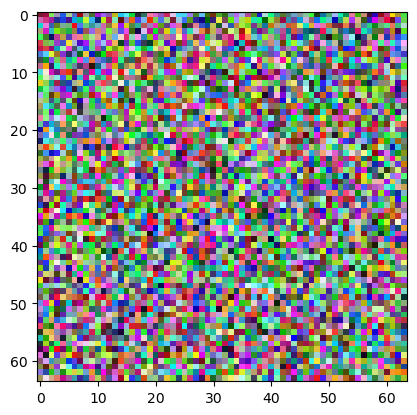

In [4]:
# size of the image (N,RGB,width,height)
imgSize = (1,3,64,64)
img = torch.rand(imgSize)

# In pytorch channels became before the width and height, but in matplotlib is the opposite (width, height, channels)
img2view = img.permute(2,3,1,0).detach().numpy()
print(img.shape)
print(img2view.shape)
print(np.squeeze(img2view).shape)
plt.imshow(np.squeeze(img2view))


In [6]:
# convolve image with filter bank (set 'outChans' filters)
convRes = conv(img)
print('Size of image:', img.shape)
print('Size of convRes:', convRes.shape)

Size of image: torch.Size([1, 3, 64, 64])
Size of convRes: torch.Size([1, 15, 60, 60])


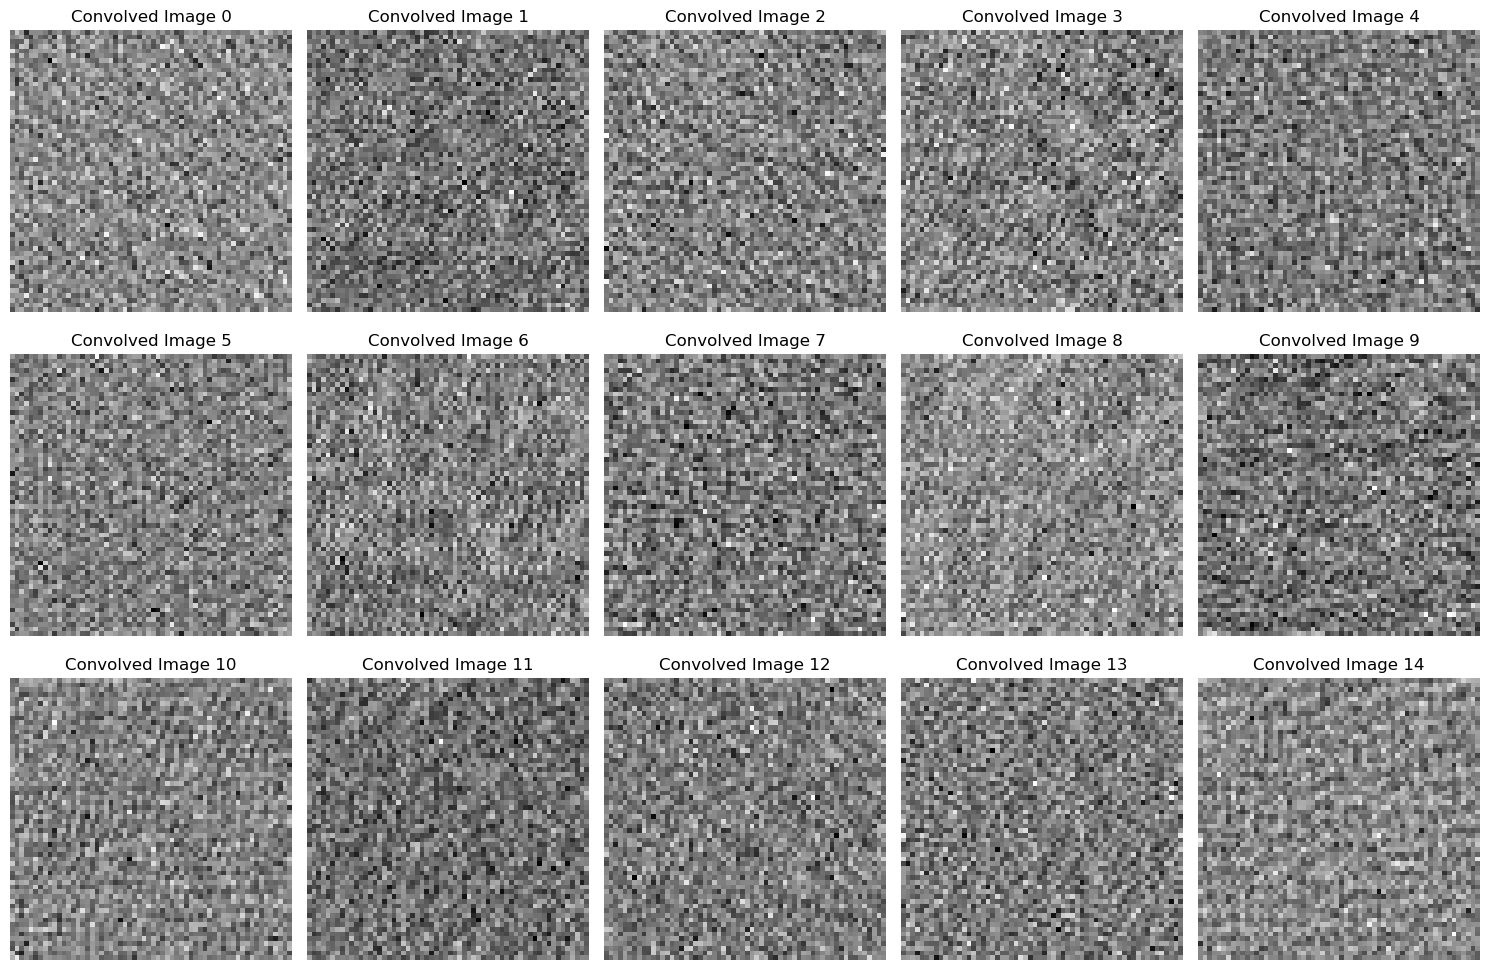

In [7]:
# What do the convolved images look like?

fig,axs = plt.subplots(3,5, figsize=(15,10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(torch.squeeze(convRes[0,i,:,:]).detach(), cmap='gray')
    ax.set_title(f'Convolved Image {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()

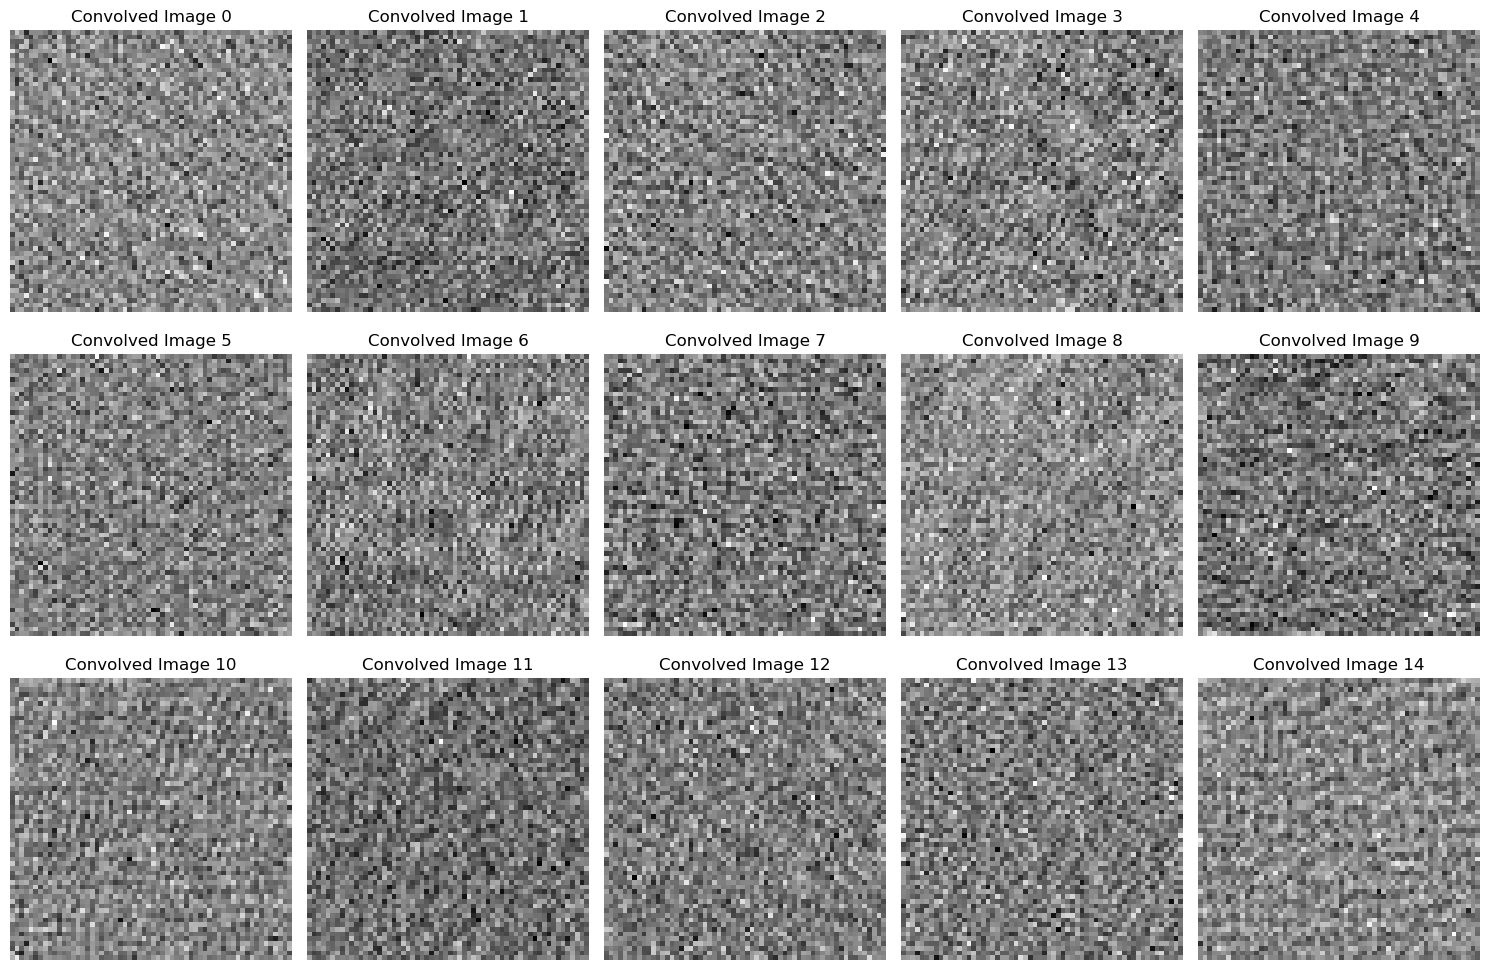

In [10]:
# This is the same as the previous cell, here we just squeeze the first dimension of the tensor

fig,axs = plt.subplots(3,5, figsize=(15,10))
for i, ax in enumerate(axs.flatten()):
    I = torch.squeeze(convRes).detach()
    ax.imshow(I[i,:,:], cmap='gray')
    ax.set_title(f'Convolved Image {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Transpose convolution

 - Transpose convolution means to scaler-multiply a kernel by each pixel in an image.

 - As long as the kernel is $ > 1 $ pixel, the result will be higher resolution than the original image.

 - Transpose convolution is used for `autoencoders` and `super-resolution` CNNs.

 - Transpose convolution takes the same parameters as forward convolution : kernel size, padding , stride.

 - Formula: $$ Result Size=(Image Size−1)×Stride+Kernel Size $$

 ![Transpose convolution](./assets/conv1.png)

## Avg pooling and max pooling

 - Max pooling take the maximum of items.

 - Mean pooling take the average or it convolution by the kernel             $$
            \begin{bmatrix}
            .25 & .25 & ..  \\
            .25 & .25 & ..\\
            .. & .. & .. \\
            \end{bmatrix}
            $$

  - Pooling reduce dimensionality (fewer parameters)

  - Selects for features over a broader spatial area (increased `receptive field` size which is the region of the input image that a neuron "sees").

  - When we go deeper into the model we want more channels (feature maps) with fewer pixels. This makes the representations increasingly abstract.
        
  - Early layers capture low-level features (e.g., edges, textures).

  - Deeper layers capture high-level features (e.g., shapes, objects).

  - **Max or Mean?**   

    - `Max pooling` : 

       - Highlights sharp features, This is often used for increasing the contrast when we have large differences in pixel intensity values between neighboring pixels and that's exacly the difinition of an edge.

       - Useful for sparse data (Like night sky picture where there is a lot of darkness which has relativaly low density and stars which has relativaly higher densities).

    - `Mean pooling`:

       - Smooths images (it's low pass filter and a dwon-sampling operation).

       - Useful for noisy data and to reduce the impact of outliers on learning.   
  - **Gaols of pooling**:

    - Pooling reduces the spatial size of the image with each successive network layer.

    - Pooling allows the model to detect one feature anywhere in the image which increase the receptive field size.   

  - **Parameters of pooling**:

    - `Spatial extent` (kernel size in convolution): The size of the pooling window, typically set to 2 or 3.

    - `Stride`: The distance between adjacent pooling windows, typically is the same with spatial extent to produce non-overlapping pooling windows. We can also set the stride < kernel size to have overlapping pooling windows which is less common.

    - When kernel and stride are the same the image is down-sampled by a factor of their value.

    - If the stride is lower than the kernel size there is an overlapping and that kind of defeat the purpose of pooling because there will be a redundancy or loss(in case of window has empty column) of information

In [4]:
# create class of pooling

# params
poolSize = 3
stride = 3

p2 = nn.MaxPool2d(poolSize, stride=stride)
p3 = nn.MaxPool3d(poolSize, stride=stride) # 3D pooling will pool on the whole 3 dimesnions

print(p2)
print(p3)

# ceiling_mode is False which mean avoiding the edges (loss of information)

MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)


In [11]:
img2D = torch.rand(1,1,30,30)
img3D = torch.rand(1,3,30,30)

img2Pool2 = p2(img2D)
print(img2Pool2.shape)

img3Pool2 = p2(img3D)
print(img3Pool2.shape)

img3Pool3 = p3(img3D)
print(img3Pool3.shape)


torch.Size([1, 1, 10, 10])
torch.Size([1, 3, 10, 10])
torch.Size([1, 1, 10, 10])


In [12]:
# create simple CNN

littleNet = nn.Sequential(
    # the conv-pool block
    nn.Conv2d(3,10,5,3,2), # convolution layer
    nn.ReLU(), # activation function
    nn.AvgPool3d(3,3), # avg pool

    # the FFN block
    nn.Flatten(), # vectorize the get from image to linear
    nn.Linear(100, 10), # FC layer
    nn.Softmax() # output activation
)


## Transforming images

 - Pre-trained CNNs are coded for certain image sizes. We might need to resize our images to work,or convert to gray-scale.

 - Transforming images changes raw pixel values without changing the image information. Transformers are thus a way to increase the total amount of data (data augmentation).

In [14]:
cdata = torchvision.datasets.CIFAR10(root='../data/cifar',download=True)

100%|██████████| 170M/170M [03:52<00:00, 735kB/s]  


In [17]:
print(cdata.data.shape)
print(cdata.classes)

(50000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


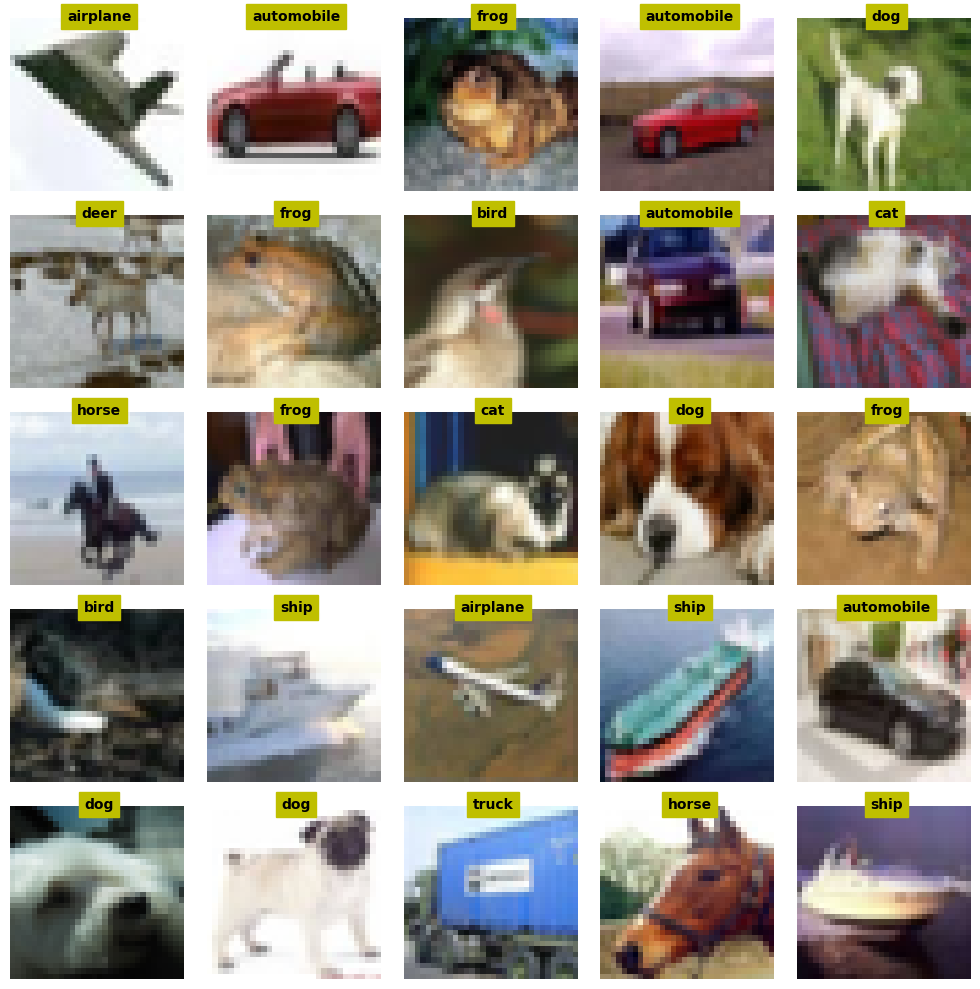

In [23]:
# Inspecting few images

fig,axs = plt.subplots(5,5,figsize=(10,10))
for ax in axs.flatten():
    randidx = np.random.choice(len(cdata.targets))
    pic = cdata.data[randidx,:,:,:]
    label = cdata.classes[cdata.targets[randidx]]
    ax.imshow(pic)
    ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()


### Apply some transormations

In [35]:
Ts = T.Compose([
    T.ToTensor(), # convert PIL image or numpy.ndarray to tensor and it is also normalizing the data to range [0,1]
    T.Resize(32*5), # increase the size of the image
    T.Grayscale(num_output_channels=1)
])

cdata.transform = Ts

# Important! adding a transform does not change the image data
print(cdata.data[123,:,:,:].shape)

(32, 32, 3)


torch.Size([1, 160, 160])


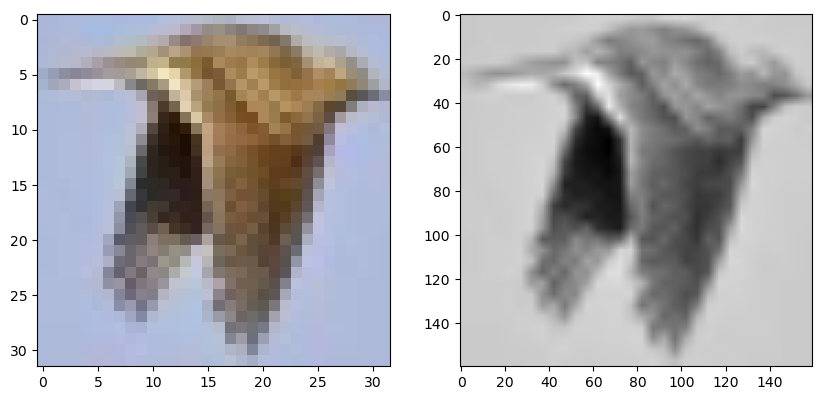

In [36]:
# apply transformation

# option 1 : apply the transfomation externally to an image 
img1 = Ts(cdata.data[123,:,:,:])
print(img1.shape)
# option 2 : use the embedded transform
fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(cdata.data[123,:,:,:])
ax[1].imshow(img1.squeeze(),cmap='gray')
plt.show()


## Custom dataset

In [18]:
df = pd.read_csv('../data/mnist_test.csv')
df.head()

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
data = df.values

In [20]:
labels = data[:8,0]
data = data[:8,1:]

print(data.shape)

(8, 784)


In [22]:
# resahpe to 2D since it is in one vector
data = data.reshape(data.shape[0],1,28,28)

In [23]:
data.shape

(8, 1, 28, 28)

In [24]:
# convert into torch tensor format
labelT = torch.tensor(labels,dtype=torch.long)
dataT = torch.tensor(data,dtype=torch.float32)

In [33]:
tensors = (dataT, labelT)
tensors[0].shape[0]

8

In [ ]:
class CustomDataset(Dataset):
    def __init__(self,tensors,transform=None):
       self.tensors = tensors # tensors is a tuple
       self.transform = transform

    def __len__(self):
        return self.tensors[0].shape[0]

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.tensors[0][index]) # tensors[0] is the data
        else:
            x = self.tensors[0][index]
        y = self.tensors[1][index]
        return x,y    

In [54]:
# data -> dataset -> dataloader
# Note that several transformers work only on PIL-format data,
# So it's common to transform to PIL ,apply transformations then transfrom back to tensor 

imgTrans = T.Compose([
    T.ToPILImage(),
    T.RandomVerticalFlip(p=.8),
    T.ToTensor()
])

In [55]:
train_data = CustomDataset(tensors,transform=imgTrans)
dataLoader = DataLoader(train_data,batch_size=8,shuffle=False)

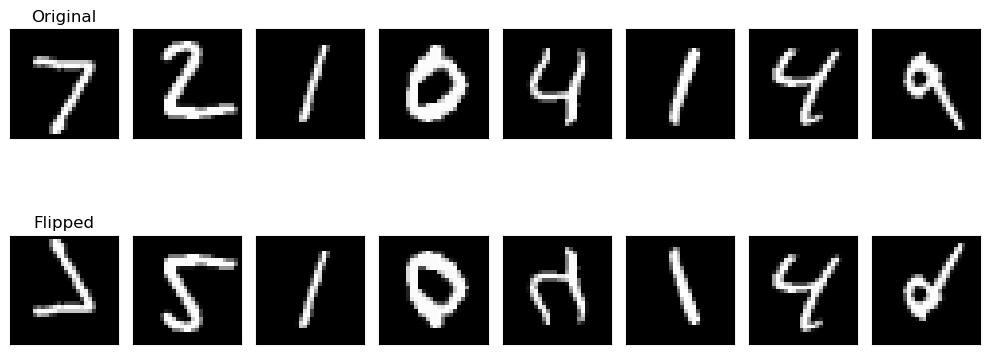

In [62]:
X,y = next(iter(dataLoader))
fig,axs = plt.subplots(2,8,figsize=(10,5))
for i in range(8):
    axs[0,i].imshow(dataT[i,0,:,:].detach(),cmap='gray')
    axs[1,i].imshow(X[i,0,:,:].detach(),cmap='gray')
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    
axs[0,0].set_title('Original')
axs[1,0].set_title('Flipped')
plt.tight_layout()
plt.show()





## Backpropagation Example

### 1 - Setup
- **Input**: 3x3 matrix:

$$  \begin{bmatrix} 1 & 2 & 3 \\ 4 & 5 & 6 \\ 7 & 8 & 9  \end{bmatrix}  $$

- **Filter**: 2x2 matrix (initial weights):
Let’s initialize: w1 = 1, w2 = 0, w3 = 0, w4 = -1.
- **Output**: 2x2 feature map (stride 1, no padding).
- **Target**: Desired output (for simplicity, a 2x2 matrix):

$$  \begin{bmatrix} 0 & 0 \\ 0 & 0  \end{bmatrix}  $$

- **Loss**: Mean Squared Error (MSE), $  L = \frac{1}{4} \sum (output - target)^2  $.

### 2 - Forward Pass
Compute the output feature map:
1. (0,0): (1×1) + (2×0) + (4×0) + (5×-1) = 1 - 5 = **-4**
2. (0,1): (2×1) + (3×0) + (5×0) + (6×-1) = 2 - 6 = **-4**
3. (1,0): (4×1) + (5×0) + (7×0) + (8×-1) = 4 - 8 = **-4**
4. (1,1): (5×1) + (6×0) + (8×0) + (9×-1) = 5 - 9 = **-4**

Output:

$$  \begin{bmatrix} -4 & -4  \\ -4 & - 4  \end{bmatrix}  $$



- Loss:
 $  L = \frac{1}{4} [(-4-0)^2 + (-4-0)^2 + (-4-0)^2 + (-4-0)^2] = \frac{1}{4} [16 + 16 + 16 + 16] = 16  $.

### 3 - Backward Pass
Goal is  Compute $  \frac{\partial L}{\partial w1}, \frac{\partial L}{\partial w2}, \frac{\partial L}{\partial w3}, \frac{\partial L}{\partial w4}  $ to update the filter.

1. **Gradient of Loss w.r.t. Output** ($  \frac{\partial L}{\partial O}  $):
    - $  L = \frac{1}{4} \sum (O[i,j] - T[i,j])^2  $

    - $  \frac{\partial L}{\partial O[i,j]} = \frac{1}{4} \cdot 2 (O[i,j] - T[i,j]) = \frac{1}{2} (O[i,j] - 0) = \frac{1}{2} O[i,j]  $

   - For each output:
     - $  \frac{\partial L}{\partial O[0,0]} = \frac{1}{2} (-4) = -2  $
     - Same for all: **-2 everywhere**.
   - Gradient matrix:

   $$  \begin{bmatrix} -2 & -2  \\ -2 & -2  \end{bmatrix}  $$



   
2. **Gradient of Filter Weights**:
- Each output $$  O[i,j]  $$ is a convolution of the input with the filter.
$$  \frac{\partial L}{\partial w_k} = \sum_{i,j} \frac{\partial L}{\partial O[i,j]} \cdot \frac{\partial O[i,j]}{\partial w_k}  $$
- $  \frac{\partial O[i,j]}{\partial w_k}  $ is the input value that $  w_k  $ was multiplied by.

- For $  w1  $ (top-left of filter):
  - $  O[0,0] = 1 \cdot w1 + \cdots  $, so $  \frac{\partial O[0,0]}{\partial w1} = 1  $
  - $  O[0,1] = 2 \cdot w1 + \cdots  $, so $  \frac{\partial O[0,1]}{\partial w1} = 2  $
  - $  O[1,0] = 4 \cdot w1 + \cdots  $, so $  \frac{\partial O[1,0]}{\partial w1} = 4  $
  - $  O[1,1] = 5 \cdot w1 + \cdots  $, so $  \frac{\partial O[1,1]}{\partial w1} = 5  $
  - Total: $  \frac{\partial L}{\partial w1} = (-2 \cdot 1) + (-2 \cdot 2) + (-2 \cdot 4) + (-2 \cdot 5) = -2 - 4 - 8 - 10 = -24  $

- For $  w2  $ Multiplies 2, 3, 5, 6:
   $$  \frac{\partial L}{\partial w2} = (-2 \cdot 2) + (-2 \cdot 3) + (-2 \cdot 5) + (-2 \cdot 6) = -4 - 6 - 10 - 12 = -32  $$

- For $  w3  $ Multiplies 4, 5, 7, 8:
   $$ \frac{\partial L}{\partial w3} = (-2 \cdot 4) + (-2 \cdot 5) + (-2 \cdot 7) + (-2 \cdot 8) = -8 - 10 - 14 - 16 = -48  $$

- For $ w4  $ Multiplies 5, 6, 8, 9:
   $$  \frac{\partial L}{\partial w4} = (-2 \cdot 5) + (-2 \cdot 6) + (-2 \cdot 8) + (-2 \cdot 9) = -10 - 12 - 16 - 18 = -56  $$

Filter gradients:

$$  \begin{bmatrix} -24 & -32  \\ -48 & - 56  \end{bmatrix}  $$


3. **Update Weights**:
- Learning rate = 0.1 (arbitrary choice).
- $  w_{new} = w_{old} - \text{learning rate} \cdot \frac{\partial L}{\partial w}  $:
  - $  w1 = 1 - 0.1 \cdot (-24) = 1 + 2.4 = 3.4  $
  - $  w2 = 0 - 0.1 \cdot (-32) = 0 + 3.2 = 3.2  $
  - $  w3 = 0 - 0.1 \cdot (-48) = 0 + 4.8 = 4.8  $
  - $  w4 = -1 - 0.1 \cdot (-56) = -1 + 5.6 = 4.6  $

Updated filter:
$$  \begin{bmatrix} 3.4 & 3.2  \\ 4.8 & 4.6  \end{bmatrix}  $$



